In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from nltk.corpus import stopwords
import re

# projections dataframe (defines images as frontal or lateral)
proj = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')

# reports dataframe (XML reports in dataframe format)
reports = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# labels for IU-Xray reports
with open('/kaggle/input/labels-14/labels_14.pickle','rb') as myfile:
    labels = pickle.load(myfile)

# labels for mimic_cxr
with open('/kaggle/input/mcxrlabels/labels_14.pickle','rb') as myfile:
    cxr_labels = pickle.load(myfile)

# read example image
img = mpimg.imread('/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1000_IM-0003-1001.dcm.png')

label_map = {
    0:'Enlarged Cardiomediastinum',
    1:'Cardiomegaly',
    2:'Lung Opacity',
    3:'Lung Lesion',
    4:'Edema',
    5:'Consolidation',
    6:'Pneumonia',
    7:'Atelectasis',
    8:'Pneumothorax',
    9:'Pleural Effusion',
    10:'Pleural Other',
    11:'Fracture',
    12:'Support Devices',
    13:'No Finding'
}

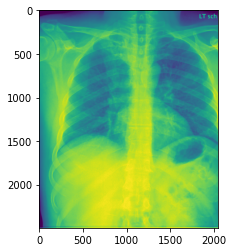

In [2]:
# showing an example image from a patient
plt.imshow(img)
plt.show()

In [3]:
max([pixel for row in img for pixel in row])

1.0

The cells below are combining the iu_xray labels with the projections and report dataframes. This will make visualization easier.

In [4]:
# changing the filenames in projection dataframe copy to match the keys in the labels dataframe
proj1 = proj.copy()
proj1['filename'] = ['CXR'+('-').join(elem.split('-')[0:2]) for elem in proj1.filename]

# adding labels to projection dataframe copy
proj1['label'] = [np.argmax(labels[key]) if key in labels.keys() else None for key in proj1.filename]
proj1.head()

,uid,filename,projection,label
0,1,CXR1_IM-0001,Frontal,NaN
1,1,CXR1_IM-0001,Lateral,NaN
2,2,CXR2_IM-0652,Frontal,13.0
3,2,CXR2_IM-0652,Lateral,13.0
4,3,CXR3_IM-1384,Frontal,NaN


In [5]:
# adding labels to reports dataframe copy
reports1 = reports.copy()
reports1 = reports1.set_index('uid')
reports1['label'] = proj1.groupby('uid').mean()
print(sum(list(reports1.label.value_counts())))
reports1.head()

2954


,MeSH,Problems,image,indication,comparison,findings,impression,label
uid,,,,,,,,
1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,NaN
2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,13.0
3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",NaN
4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,2.0
5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,13.0


In [6]:
# the only UID (label key) missing from the projection/reports dataframe
[key for key in labels.keys() if key not in list(proj1.filename)]

['CXR1_1_IM-0001']

Patient 343
label: 4
['343_IM-1658-1001.dcm.png', '343_IM-1658-2001.dcm.png']


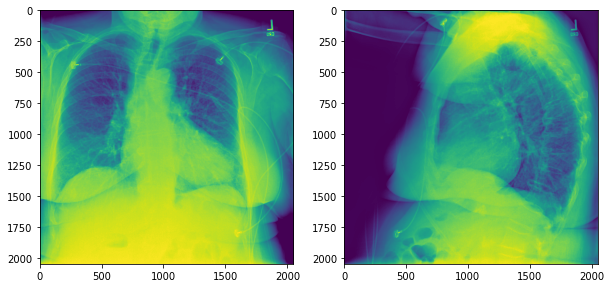

MeSH: Consolidation/lung;Bone Diseases, Metabolic;Airspace Disease/lung;Pulmonary Congestion/mild 

Findings: Heart size and mediastinal contour are normal. Pulmonary vascularity is normal. is not diffuse interstitial prominence, which has chronic appearance. Cannot exclude early pulmonary edema. Two airspace consolidation or effusion. XXXX are osteopenic. No visible pneumothorax.


In [7]:
idx, cntr = 30, 0 # index is based on the index of the label keys
print('Patient', list(proj1[proj1.filename==list(labels.keys())[idx]].uid)[0])
print('label:',np.argmax(labels[list(labels.keys())[idx]]))
idxs = list(proj1[proj1.filename==list(labels.keys())[idx]].index)
img_names = list(proj.iloc[idxs].filename)
print(img_names)
fig, axes = plt.subplots(1,len(img_names), figsize=(5*len(img_names),5))
for img in img_names:
    disp_img = mpimg.imread('/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'+img)
    axes[cntr].imshow(disp_img)
    cntr+=1
plt.show()
print('MeSH:', reports[reports.uid==proj.iloc[idxs].uid.values[0]].MeSH.values[0],'\n')
print('Findings:', reports[reports.uid==proj.iloc[idxs].uid.values[0]].findings.values[0])

In [8]:
corpus = {} # store all occurences of words contained in findings

all_findings = list(reports.findings.values)
for finding in all_findings:
    if type(finding)==str:
        finding = re.sub(r'[^\w\s]', '', finding)
        lower_finding = finding.lower()
        split_finding = lower_finding.split(' ')
        for word in split_finding:
            if word not in stopwords.words('english'):
                if word not in corpus:
                    corpus[word] = 1
                else:
                    corpus[word] += 1

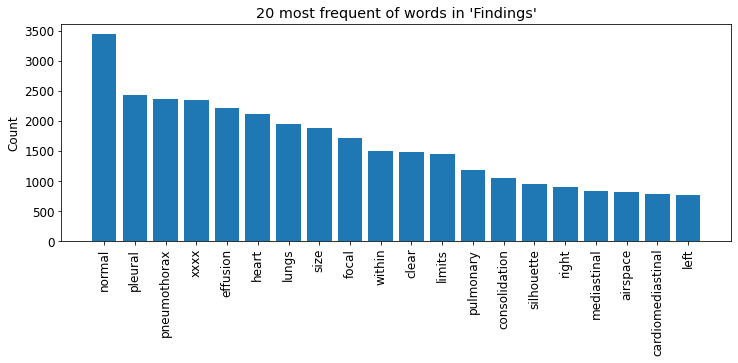

In [9]:
# sort corpus dictionary by value
top = 20
corpus = dict(sorted(corpus.items(), key = lambda item: item[1], reverse=True))
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12,4))
plt.bar(list(corpus.keys())[:top], list(corpus.values())[:top])
plt.title("{} most frequent of words in 'Findings'".format(top))
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# of classes: (14,)
# of samples: 2955 



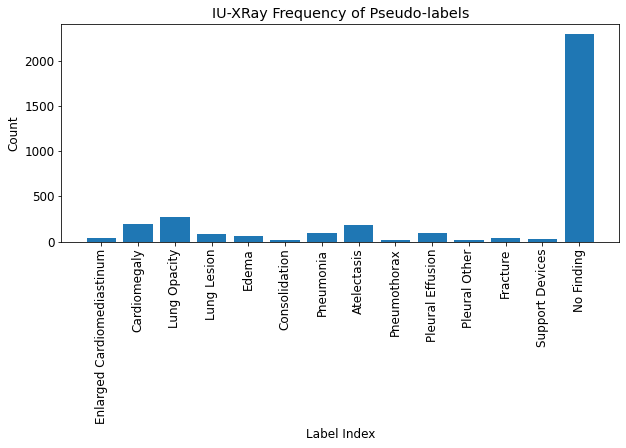

% of data with 14th label: 0.6640602374746597


In [10]:
print('# of classes:',list(labels.values())[0].shape)
# There appears to be 14 classes

print('# of samples:',len(list(labels.keys())),'\n')
# Nearly 3000 labels

vals = [label_map[i] for i in range(0,14)]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.bar(vals, sum(list(labels.values())))
plt.title('IU-XRay Frequency of Pseudo-labels')
plt.ylabel('Count')
plt.xlabel('Label Index')
plt.xticks(rotation=90)
plt.show()

print('% of data with 14th label:',sum(list(labels.values()))[-1]/sum(sum(list(labels.values()))))

# of classes: (14,)
# of samples: 377110 



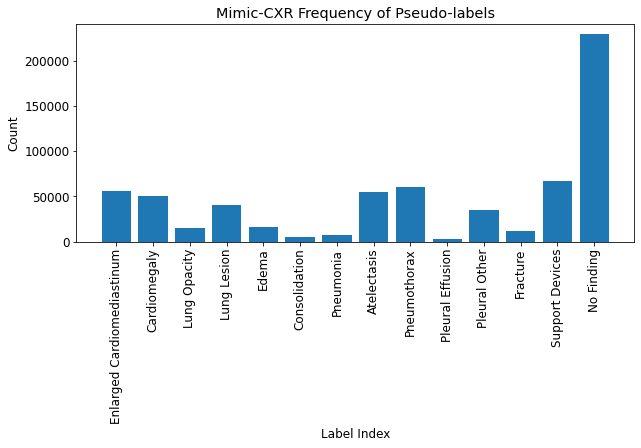

% of data with 14th label: 0.3521075804216387


In [11]:
print('# of classes:',list(cxr_labels.values())[0].shape)
# There appears to be 14 classes

print('# of samples:',len(list(cxr_labels.keys())),'\n')
# Nearly 3000 labels

vals = [label_map[i] for i in range(0,14)]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.bar(vals, sum(list(cxr_labels.values())))
plt.title('Mimic-CXR Frequency of Pseudo-labels')
plt.ylabel('Count')
plt.xlabel('Label Index')
plt.xticks(rotation=90)
plt.show()

print('% of data with 14th label:',sum(list(cxr_labels.values()))[-1]/sum(sum(list(cxr_labels.values()))))

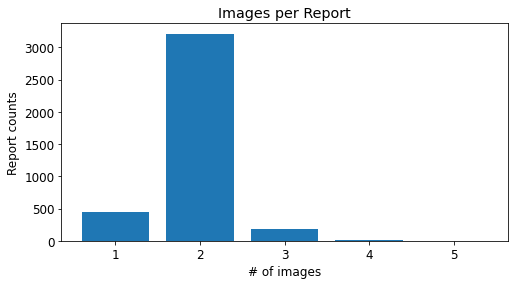

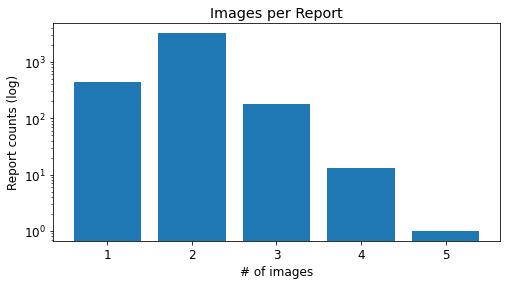

In [12]:
img_per_rep = proj.groupby('uid').count().filename.value_counts()
plt.figure(figsize=(8,4))
plt.bar(img_per_rep.keys(), img_per_rep.values)
plt.title('Images per Report')
plt.ylabel('Report counts')
plt.xlabel('# of images')
plt.show()

plt.figure(figsize=(8,4))
plt.bar(img_per_rep.keys(), img_per_rep.values)
plt.title('Images per Report')
plt.yscale('log')
plt.ylabel('Report counts (log)')
plt.xlabel('# of images')
plt.show()

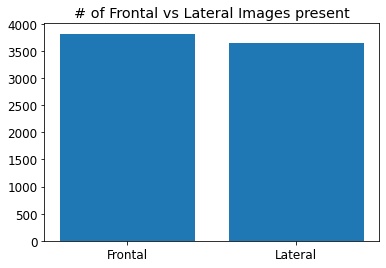

['Frontal' 'Lateral']    3388
['Frontal']               301
['Lateral']               162
dtype: int64

In [13]:
plt.bar(proj1.projection.value_counts().keys(), list(proj1.projection.value_counts()))
plt.title('# of Frontal vs Lateral Images present')
plt.show()

# number of image types
proj1.groupby('uid').nunique().projection.value_counts()

# count of image types
pd.Series([str(i) for i in proj1.groupby('uid')['projection'].agg(['unique']).unique]).value_counts()

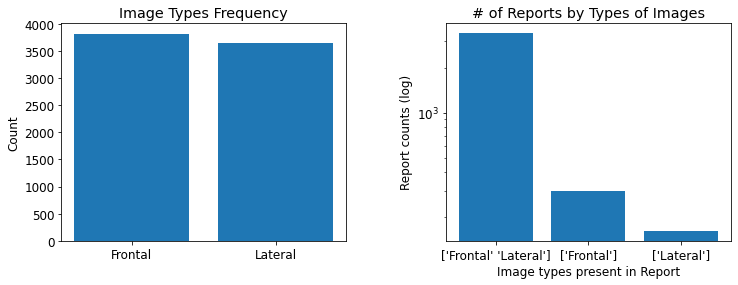

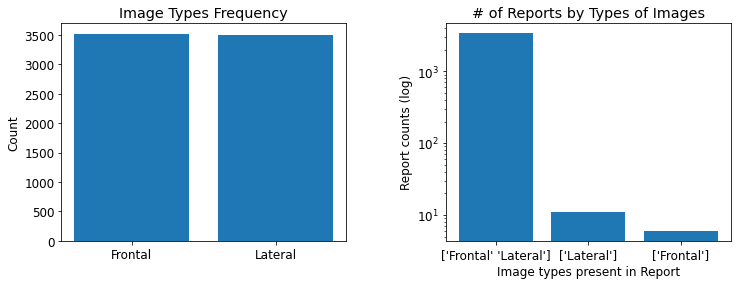

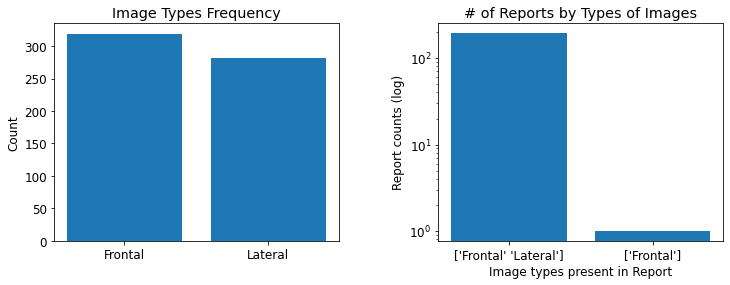

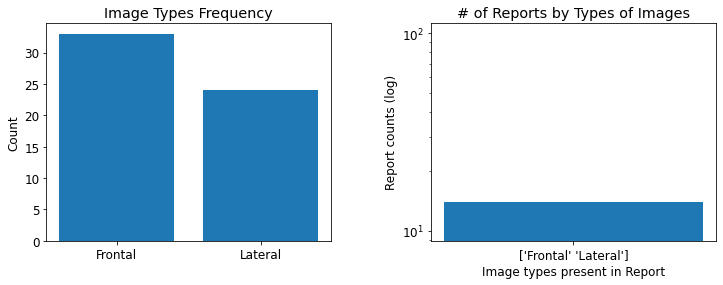

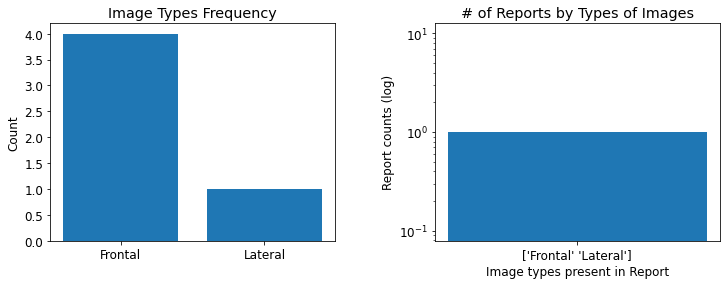

In [14]:
def plot_image_types(i):
    proj2 = proj.groupby('uid').count()
    user_list = list(proj2[proj2.filename>=i].index)
    proj3 = proj1[[True if uid in user_list else False for uid in proj1.uid]]
    
    # count of image types
    val_counts = pd.Series([str(i) for i in proj3.groupby('uid')['projection'].agg(['unique']).unique]).value_counts()

    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(121)
    ax1.bar(proj3.projection.value_counts().keys(), list(proj3.projection.value_counts()))
    ax1.set_title('Image Types Frequency'.format(i))
    ax1.set_ylabel('Count')
    
    ax2 = plt.subplot(122)
    ax2.bar(val_counts.keys(), list(val_counts))
    ax2.set_title('# of Reports by Types of Images'.format(i))
    ax2.set_ylabel('Report counts (log)')
    ax2.set_xlabel('Image types present in Report')
    ax2.set_yscale('log')
    plt.subplots_adjust(hspace=0.5, wspace=0.35)
    plt.show()
plot_image_types(1)
plot_image_types(2)
plot_image_types(3)
plot_image_types(4)
plot_image_types(5)

In [15]:
normal_reports = reports1[reports1.label==13]
non_normal_reports = reports1[reports1.label!=13]

normal_corpus = {} # store all occurences of words contained in findings (normal pseudo-label)
all_findings = list(normal_reports.findings.values)
for finding in all_findings:
    if type(finding)==str:
        finding = re.sub(r'[^\w\s]', '', finding)
        lower_finding = finding.lower()
        split_finding = lower_finding.split(' ')
        for word in split_finding:
            if word not in stopwords.words('english'):
                if word not in normal_corpus:
                    normal_corpus[word] = 1
                else:
                    normal_corpus[word] += 1
normal_corpus = dict(sorted(normal_corpus.items(), key = lambda item: item[1], reverse=True)) # sort by increasing counts


non_normal_corpus = {} # store all occurences of words contained in findings (non-normal pseudo-label)
all_findings = list(non_normal_reports.findings.values)
for finding in all_findings:
    if type(finding)==str:
        finding = re.sub(r'[^\w\s]', '', finding)
        lower_finding = finding.lower()
        split_finding = lower_finding.split(' ')
        for word in split_finding:
            if word not in stopwords.words('english'):
                if word not in non_normal_corpus:
                    non_normal_corpus[word] = 1
                else:
                    non_normal_corpus[word] += 1
non_normal_corpus = dict(sorted(non_normal_corpus.items(), key = lambda item: item[1], reverse=True)) # sort by increasing counts

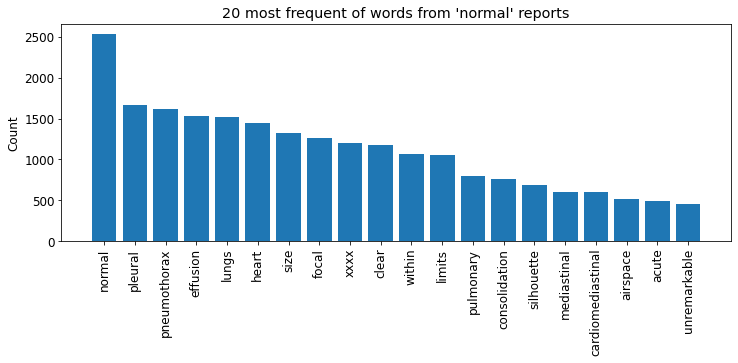

In [16]:
# sort corpus dictionary by value
top = 20
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12,4))
plt.bar(list(normal_corpus.keys())[:top], list(normal_corpus.values())[:top])
plt.title("{} most frequent of words from 'normal' reports".format(top))
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

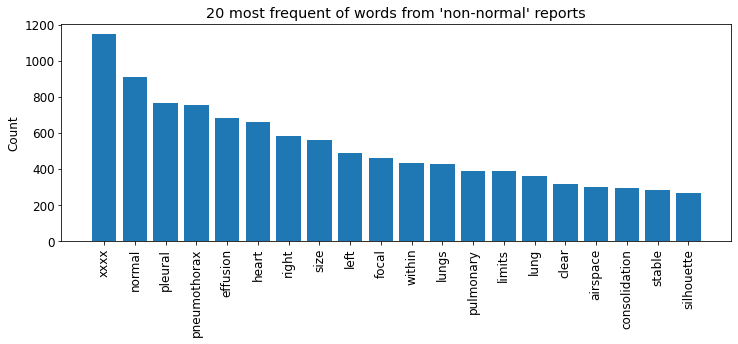

In [17]:
# sort corpus dictionary by value
top = 20
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12,4))
plt.bar(list(non_normal_corpus.keys())[:top], list(non_normal_corpus.values())[:top])
plt.title("{} most frequent of words from 'non-normal' reports".format(top))
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [27]:
list(normal_corpus.keys())[0:10], list(normal_corpus.values())[0:10]

(['normal',
  'pleural',
  'pneumothorax',
  'effusion',
  'lungs',
  'heart',
  'size',
  'focal',
  'xxxx',
  'clear'],
 [2534, 1672, 1618, 1529, 1516, 1450, 1328, 1257, 1204, 1173])

In [28]:
list(non_normal_corpus.keys())[0:10], list(non_normal_corpus.values())[0:10]

(['xxxx',
  'normal',
  'pleural',
  'pneumothorax',
  'effusion',
  'heart',
  'right',
  'size',
  'left',
  'focal'],
 [1148, 911, 766, 755, 682, 659, 583, 562, 488, 460])